### Testing Neural Network based Anomaly Detection on simulated data

#### This code generates large dataframe containing multiple timeseries, randomly adds changes in both mean and variance (anomalies), tries to train neural network to distinguish measurements belonging to the timebin under investigation from measurements in a reference time period.

In [1]:
%matplotlib inline
from time import time
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)  

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

from pandas.tseries.offsets import *

import simulated_data

Using TensorFlow backend.


#### parameters to set

In [2]:
# parameters of simulated data generation
n_series = 6

# lenghts of subject and reference time periods
refh = 12
subh = 1

# probability to correctly classify sample based purely on luck
chance = refh/(subh+refh)
# how much better than luck we want to be to say we detected an anomaly. Default is 5%
cut = chance + (1-chance) * 0.05

print('chance:',chance, '\tcut:', cut)
ref = refh * Hour()
sub = subh * Hour()

# number of training epochs 
epochs=60

chance: 0.9230769230769231 	cut: 0.926923076923077


#### generate normal data

In [3]:
df =  simulated_data.get_simulated_data()
# df =  simulated_data.get_simulated_fixed_data()
df.head()

affected: [2 5] 2017-08-03 07:36:42 2017-08-03 07:58:06
affected: [2 0 1 4] 2017-08-01 06:23:52 2017-08-01 07:06:09
affected: [1 3 2 4 5] 2017-08-05 18:30:38 2017-08-05 19:24:01
affected: [5 2 3] 2017-08-02 11:27:58 2017-08-02 12:21:16
affected: [2 1 4 0 5] 2017-08-05 07:20:14 2017-08-05 10:35:35
affected: [3 1] 2017-08-03 19:20:06 2017-08-03 20:17:46


,link 0,link 1,link 2,link 3,link 4,link 5,flag
2017-08-01 00:00:00,0.234309,0.098391,0.546828,0.290921,0.403015,0.245851,0
2017-08-01 00:00:01,0.230034,0.134577,0.548541,0.288414,0.399936,0.238371,0
2017-08-01 00:00:02,0.225711,0.127967,0.539710,0.287345,0.393710,0.243551,0
2017-08-01 00:00:03,0.231239,0.127110,0.543637,0.283620,0.401527,0.236844,0
2017-08-01 00:00:04,0.231674,0.141980,0.546474,0.290413,0.396456,0.235442,0


#### plot timeseries

Text(0.5,0,'time')

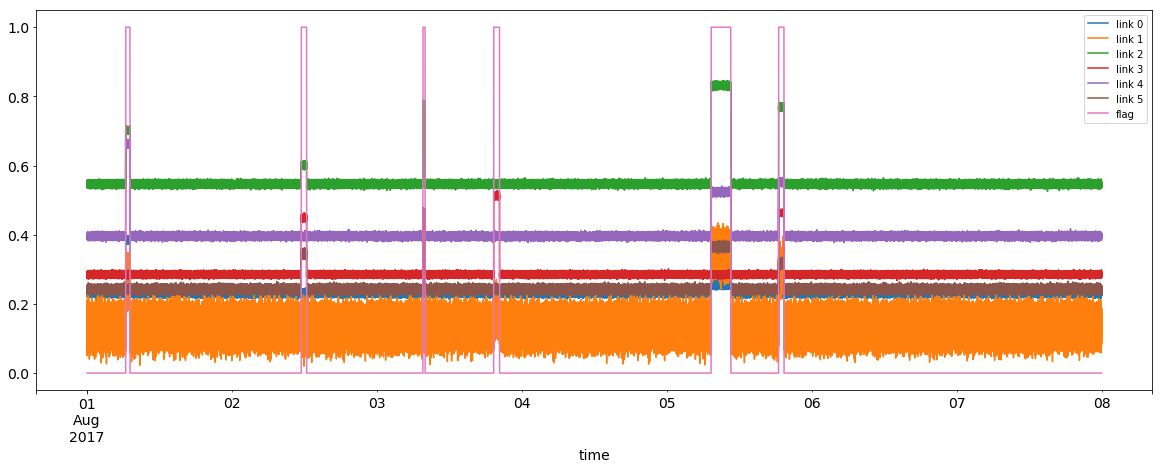

In [4]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)

#### create NN

In [5]:
def getModel():
    model = Sequential()
    model.add(Dense(units=n_series, input_shape=(n_series,), activation='relu' ))
#         model.add(Dropout(0.5))
    model.add(Dense(units=n_series, activation='relu'))    
#         model.add(Dropout(0.5))
    model.add(Dense(units=1, activation='sigmoid') )
    
    model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='hinge', optimizer='sgd', metrics=['binary_accuracy'])
#         model.compile(loss='mse',optimizer='rmsprop', metrics=['accuracy'])
#         model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['binary_accuracy'])
        
    return model

def plotHist(hist):
    es=len(hist.history['loss'])
    x = np.linspace(0,es-1,es)
    plt.plot(x, hist.history['loss'], '--', linewidth=2, label='loss')
    plt.plot(x, hist.history['acc'], '-', linewidth=2, label='acc')
    plt.legend()
    plt.show()

#### This function actually checks for anomaly in one time window. It receives both referent period and subject period (one under investigation). If splits in samples in training and testing parts, shuffle them and trains model. If anomaly has been detected it plots ROC. It returns both loss and accuracy.

In [6]:
def check_for_anomaly(ref, sub, count):
    
    y_ref = pd.DataFrame([0] * ref.shape[0])
    y_ref.index=ref.index
    X_ref=ref
    del X_ref['flag']
    del X_ref['score']
    
    y_sub = pd.DataFrame([1] * sub.shape[0])
    y_sub.index=sub.index
    X_sub=sub
    del X_sub['flag']
    del X_sub['score']
    
    # separate Reference and Subject into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size=0.3, random_state=42)
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size=0.3, random_state=42)
    
    # combine training ref and sub samples
    X_train = pd.concat([X_ref_train, X_sub_train])
    y_train = pd.concat([y_ref_train, y_sub_train])

    # combine testing ref and sub samples
    X_test = pd.concat([X_ref_test, X_sub_test])
    y_test = pd.concat([y_ref_test, y_sub_test])
    
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    X_train_s, y_train_s = shuffle(X_train, y_train)
    
    m=getModel()
    hist = m.fit(X_train_s.values, y_train_s.values, epochs=epochs, verbose=0, shuffle=True, batch_size=256)

    
    loss_and_metrics = m.evaluate(X_test.values, y_test.values)#, batch_size=256)
    #print(loss_and_metrics)

    if loss_and_metrics[1] > cut:# or not count%5: 
        plotHist(hist)
        
    return loss_and_metrics[1]

#### Looping over time intervals

0
14040/14040 [==============================] - 1s 44us/step

 2017-08-01 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.58830451965332
1
14040/14040 [==============================] - 1s 41us/step

 2017-08-01 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.619889736175537
2
14040/14040 [==============================] - 1s 42us/step

 2017-08-01 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.705970287322998
3
14040/14040 [==============================] - 1s 42us/step

 2017-08-01 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 26.575162887573242
4
14040/14040 [==============================] - 1s 43us/step

 2017-08-01 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.844260215759277
5
14040/14040 [==============================] - 1s 44us/step

 2017-08-01 18:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 25.898683547973633
6
14040/14040 [==============

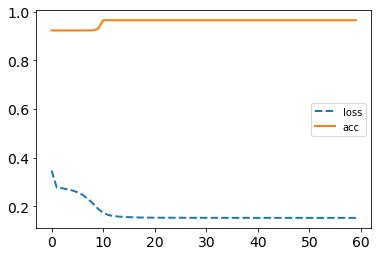


 2017-08-02 12:00:00 	refes: 43200 	subjects: 3600 	score: 0.962179487163
took: 27.227049112319946
24
14040/14040 [==============================] - 1s 60us/step

 2017-08-02 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.245615243911743
25
14040/14040 [==============================] - 1s 61us/step

 2017-08-02 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.53496217727661
26
14040/14040 [==============================] - 1s 64us/step

 2017-08-02 15:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.068129777908325
27
14040/14040 [==============================] - 1s 65us/step

 2017-08-02 16:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.293315887451172
28
14040/14040 [==============================] - 1s 70us/step

 2017-08-02 17:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 27.462425231933594
29
14040/14040 [==============================] - 1s 74us/step

 2017-08-02 18:00:00 	

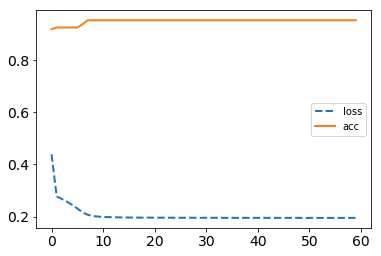


 2017-08-03 08:00:00 	refes: 43200 	subjects: 3600 	score: 0.949715099732
took: 29.11488151550293
44
14040/14040 [==============================] - 1s 82us/step

 2017-08-03 09:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 28.95608353614807
45
14040/14040 [==============================] - 1s 85us/step

 2017-08-03 10:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 29.362744331359863
46
14040/14040 [==============================] - 1s 83us/step

 2017-08-03 11:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 28.958582401275635
47
14040/14040 [==============================] - 1s 83us/step

 2017-08-03 12:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 29.27734684944153
48
14040/14040 [==============================] - 1s 84us/step

 2017-08-03 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 28.933481216430664
49
14040/14040 [==============================] - 1s 90us/step

 2017-08-03 14:00:00 	re

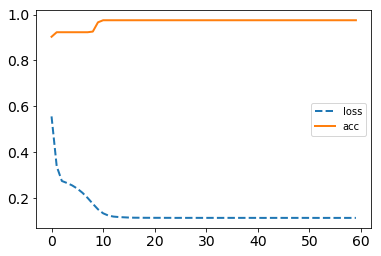


 2017-08-03 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.971866096832
took: 29.71415948867798
56
14040/14040 [==============================] - 1s 96us/step

 2017-08-03 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 29.366875171661377
57
14040/14040 [==============================] - 1s 101us/step

 2017-08-03 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 29.7621431350708
58
14040/14040 [==============================] - 1s 100us/step

 2017-08-03 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 29.916887998580933
59
14040/14040 [==============================] - 1s 106us/step

 2017-08-04 00:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 30.679760217666626
60
14040/14040 [==============================] - 1s 102us/step

 2017-08-04 01:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 29.65987777709961
61
14040/14040 [==============================] - 1s 100us/step

 2017-08-04 02:00:00

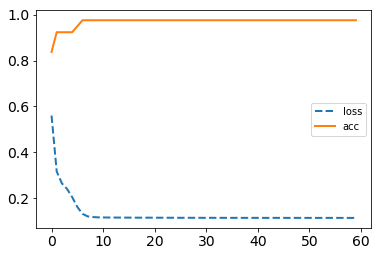


 2017-08-05 08:00:00 	refes: 43200 	subjects: 3600 	score: 0.971581196547
took: 32.53395652770996
92
14040/14040 [==============================] - 2s 137us/step


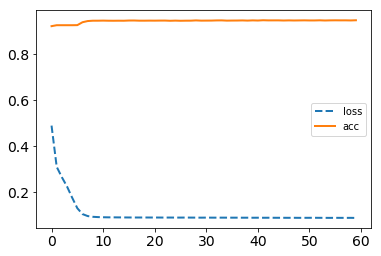


 2017-08-05 09:00:00 	refes: 43200 	subjects: 3600 	score: 0.946082621083
took: 32.82822275161743
93
14040/14040 [==============================] - 2s 134us/step

 2017-08-05 10:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 32.32757258415222
94
14040/14040 [==============================] - 2s 136us/step

 2017-08-05 11:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 32.58227896690369
95
14040/14040 [==============================] - 2s 139us/step

 2017-08-05 12:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 32.654191732406616
96
14040/14040 [==============================] - 2s 135us/step

 2017-08-05 13:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 32.73017382621765
97
14040/14040 [==============================] - 2s 138us/step

 2017-08-05 14:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 32.3121497631073
98
14040/14040 [==============================] - 2s 141us/step

 2017-08-05 15:00:00 

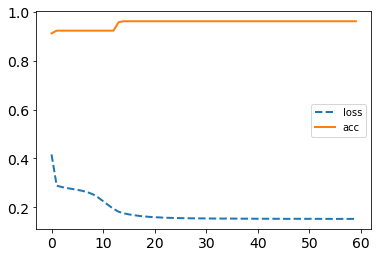


 2017-08-05 19:00:00 	refes: 43200 	subjects: 3600 	score: 0.958689458672
took: 33.87097668647766
103
14040/14040 [==============================] - 2s 139us/step

 2017-08-05 20:00:00 	refes: 43200 	subjects: 3600 	score: 0.923148148148
took: 33.46074318885803
104
14040/14040 [==============================] - 2s 146us/step

 2017-08-05 21:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 34.03948926925659
105
14040/14040 [==============================] - 2s 149us/step

 2017-08-05 22:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 33.66306161880493
106
14040/14040 [==============================] - 2s 144us/step

 2017-08-05 23:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 33.15161442756653
107
14040/14040 [==============================] - 2s 145us/step

 2017-08-06 00:00:00 	refes: 43200 	subjects: 3600 	score: 0.923076923077
took: 33.726112842559814
108
14040/14040 [==============================] - 2s 149us/step

 2017-08-06 01

In [7]:
df['score']=0.5

#find min and max timestamps

start = df.index.min()
end = df.index.max()

#round start 
start.seconds=0
start.minutes=0


# loop over them
ti=start+ref+sub
count=0
while ti < end + 1 * Minute():
    print(count)
    startt = time()
    ref_start = ti-ref-sub
    ref_end = ti-sub
    ref_df = df[(df.index >= ref_start) & (df.index < ref_end)]
    sub_df = df[(df.index >= ref_end) & (df.index < ti)]
    score = check_for_anomaly(ref_df, sub_df, count)
    df.loc[(df.index>=ref_end) & (df.index<=ti),['score']] = score
    print('\n',ti,"\trefes:" , ref_df.shape[0], "\tsubjects:", sub_df.shape[0], '\tscore:', score)
    ti = ti + sub
    count=count+1
    endt=time()
    print("took:", endt-startt)
#     if count>2: break
    


#### Plots all the series, now it includes AUC values

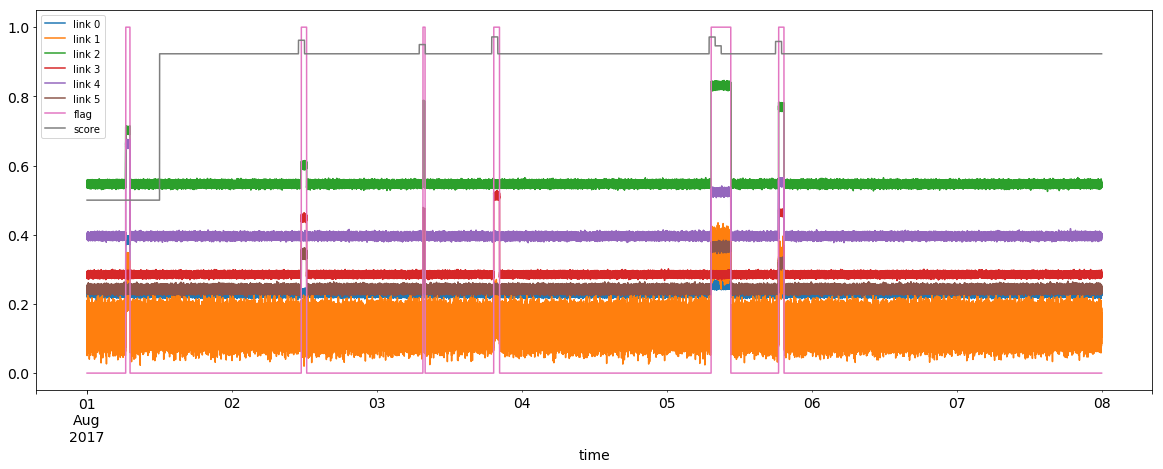

In [8]:
ax = df.plot(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
plt.savefig('ANN_simulated_score.png')

#### Plots auc and shades periods were anomaly has been detected

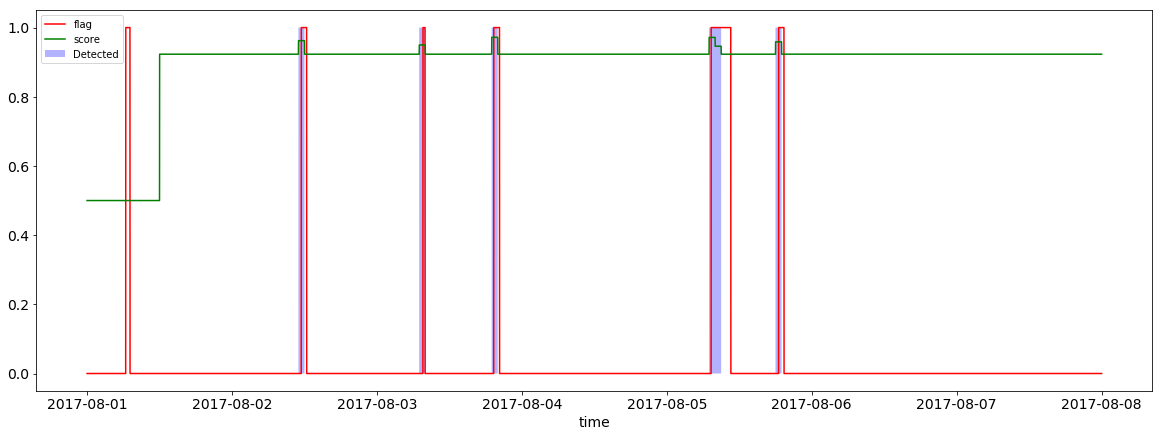

In [9]:
fig, ax = plt.subplots(figsize=(20,7))
ax.set_xlabel("time", fontsize=14)
df.loc[:,'Detected'] = 0
df.loc[df.score>cut,'Detected']=1
df.head()
ax.plot(df.flag, 'r')
ax.plot(df.score,'g')
ax.fill( df.Detected, 'b', alpha=0.3)
ax.legend(loc='upper left')
plt.show()
fig.savefig('ANN_simulated_shaded.png')